<a href="https://colab.research.google.com/github/sagihaider/COVID-19_Analysis/blob/master/Covid_19_Analysis_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 # Load Basic Libraries
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, save
import plotly.graph_objects as go
import sklearn
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pd.plotting.register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "sagihaider" # username from the json file
os.environ['KAGGLE_KEY'] = "08f30f17342835b8df3640d23ceac8f7" # key from the json file
!kaggle competitions download -c covid19-global-forecasting-week-3

  0% 0.00/825k [00:00<?, ?B/s]
100% 825k/825k [00:00<00:00, 52.9MB/s]
  0% 0.00/375k [00:00<?, ?B/s]
100% 375k/375k [00:00<00:00, 120MB/s]
  0% 0.00/118k [00:00<?, ?B/s]
100% 118k/118k [00:00<00:00, 105MB/s]


In [3]:
train_df=pd.read_csv('/content/train.csv')
test_df=pd.read_csv('/content/test.csv')
all_data=pd.concat([train_df,test_df],axis=0) # combined train and test data
all_data.reset_index(drop=True) # reset index with drop true

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId
0,1.0,NaN,Afghanistan,2020-01-22,0.0,0.0,NaN
1,2.0,NaN,Afghanistan,2020-01-23,0.0,0.0,NaN
2,3.0,NaN,Afghanistan,2020-01-24,0.0,0.0,NaN
3,4.0,NaN,Afghanistan,2020-01-25,0.0,0.0,NaN
4,5.0,NaN,Afghanistan,2020-01-26,0.0,0.0,NaN
...,...,...,...,...,...,...,...
35185,NaN,NaN,Zimbabwe,2020-05-03,NaN,NaN,13154.0
35186,NaN,NaN,Zimbabwe,2020-05-04,NaN,NaN,13155.0
35187,NaN,NaN,Zimbabwe,2020-05-05,NaN,NaN,13156.0
35188,NaN,NaN,Zimbabwe,2020-05-06,NaN,NaN,13157.0


In [4]:
train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22032 entries, 0 to 22031
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              22032 non-null  int64  
 1   Province_State  9360 non-null   object 
 2   Country_Region  22032 non-null  object 
 3   Date            22032 non-null  object 
 4   ConfirmedCases  22032 non-null  float64
 5   Fatalities      22032 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.0+ MB


In [6]:
# Get the unique countries count
train_df['Country_Region'].nunique() 

180

#### Note:
Out of 180 countries data, we have only 8 countries who has given Province wise data for Corona confirmed and fatalities. Hence, alot of this missing data would not be good for our dataset, and hence we will drop this column.

In [7]:
print("fill blanks and add region for counting")
train_df.drop('Province_State',axis=1,inplace=True)

fill blanks and add region for counting


In [0]:
# Resetting Date column into Datetime object and making it an index of dataframe
train_df['Date']=pd.to_datetime(train_df['Date'])
train_df.set_index('Date',inplace=True)

In [9]:
print(train_df)

               Id Country_Region  ConfirmedCases  Fatalities
Date                                                        
2020-01-22      1    Afghanistan             0.0         0.0
2020-01-23      2    Afghanistan             0.0         0.0
2020-01-24      3    Afghanistan             0.0         0.0
2020-01-25      4    Afghanistan             0.0         0.0
2020-01-26      5    Afghanistan             0.0         0.0
...           ...            ...             ...         ...
2020-03-29  32703       Zimbabwe             7.0         1.0
2020-03-30  32704       Zimbabwe             7.0         1.0
2020-03-31  32705       Zimbabwe             8.0         1.0
2020-04-01  32706       Zimbabwe             8.0         1.0
2020-04-02  32707       Zimbabwe             9.0         1.0

[22032 rows x 4 columns]


### Exploratory Data Analysis

We will try to answer following questions:

Q1. Which countries has high number of cases?

Q2. How is confirmed cases increases by day?

Q3. What is fatality rate of confirmed cases?

Q4. How is cases increasing by day of 1st reported case?

Q5. Understanding data of India and UK and comparing it with the world?

Q6. What is new rate of increase per case per day?

Note: My Analysis is limited to 12 Countries of interest for better understanding the spread while I will try to extend this to other countries and make Predictions of Confirmed Cases and Fatalities.

In [10]:
pivot=pd.pivot_table(train_df,columns='Country_Region',
                     index='Date',
                     values='ConfirmedCases',
                     aggfunc=np.sum)

pivot_fatality=pd.pivot_table(train_df,
                              columns='Country_Region',
                              index='Date',
                              values='Fatalities',
                              aggfunc=np.sum)
country_list=[]
value_list=[]
fatality_list=[]

for country in list(pivot.columns):
    country_list.append(country)
    value_list.append(pivot[country].max())
    fatality_list.append(pivot_fatality[country].max())
    new_dict={'Country':country_list,'Confirmed':value_list,'Fatality':fatality_list}

df=pd.DataFrame.from_dict(new_dict)
df.set_index('Country',inplace=True)
df

,Confirmed,Fatality
Country,,
Afghanistan,273.0,6.0
Albania,277.0,16.0
Algeria,986.0,86.0
Andorra,428.0,15.0
Angola,8.0,2.0
...,...,...
Venezuela,146.0,5.0
Vietnam,233.0,0.0
West Bank and Gaza,161.0,1.0


In [11]:
sortdf_conf = df.sort_values(by=['Confirmed'],ascending=False)
sortdf_fat = df.sort_values(by=['Fatality'],ascending=False)
top10_conf = sortdf_conf.head(10)
top10_fat = sortdf_fat.head(10)
print(top10_conf)
print(top10_fat)

                Confirmed  Fatality
Country                            
US               243295.0    5922.0
Italy            115242.0   13915.0
Spain            112065.0   10348.0
Germany           84794.0    1107.0
China             82432.0    3322.0
France            59929.0    5398.0
Iran              50468.0    3160.0
United Kingdom    34173.0    2926.0
Switzerland       18827.0     536.0
Turkey            18135.0     356.0
                Confirmed  Fatality
Country                            
Italy            115242.0   13915.0
Spain            112065.0   10348.0
US               243295.0    5922.0
France            59929.0    5398.0
China             82432.0    3322.0
Iran              50468.0    3160.0
United Kingdom    34173.0    2926.0
Netherlands       14786.0    1341.0
Germany           84794.0    1107.0
Belgium           15348.0    1011.0


In [12]:
# Confirmed COVID-19 Cases by country
import plotly.express as px
fig = px.bar(top10_conf, x=top10_conf.index, y='Confirmed', 
             labels={'x':'Country'}, color="Confirmed", 
             color_continuous_scale=px.colors.sequential.Rainbow_r)
fig.update_layout(title_text='Top 10 Confirmed COVID-19 cases by country')
fig.show()

fig = px.bar(top10_fat, x=top10_fat.index, y='Fatality', 
             labels={'x':'Country'}, color="Fatality", 
             color_continuous_scale=px.colors.sequential.Rainbow_r)
fig.update_layout(title_text='Top 10 Fatality COVID-19 cases by country')
fig.show()



In [13]:
# We can also sort values using this code
top_confirmed=df.sort_values(by='Confirmed',ascending=False)[:10]
top_confirmed

,Confirmed,Fatality
Country,,
US,243295.0,5922.0
Italy,115242.0,13915.0
Spain,112065.0,10348.0
Germany,84794.0,1107.0
China,82432.0,3322.0
France,59929.0,5398.0
Iran,50468.0,3160.0
United Kingdom,34173.0,2926.0
Switzerland,18827.0,536.0


In [0]:
# Make List of Top 10 Countries and India and Pakistan- The Countries of interest.
list_countries=list(top_confirmed.index)
list_countries.append('India')
list_countries.append('Pakistan')

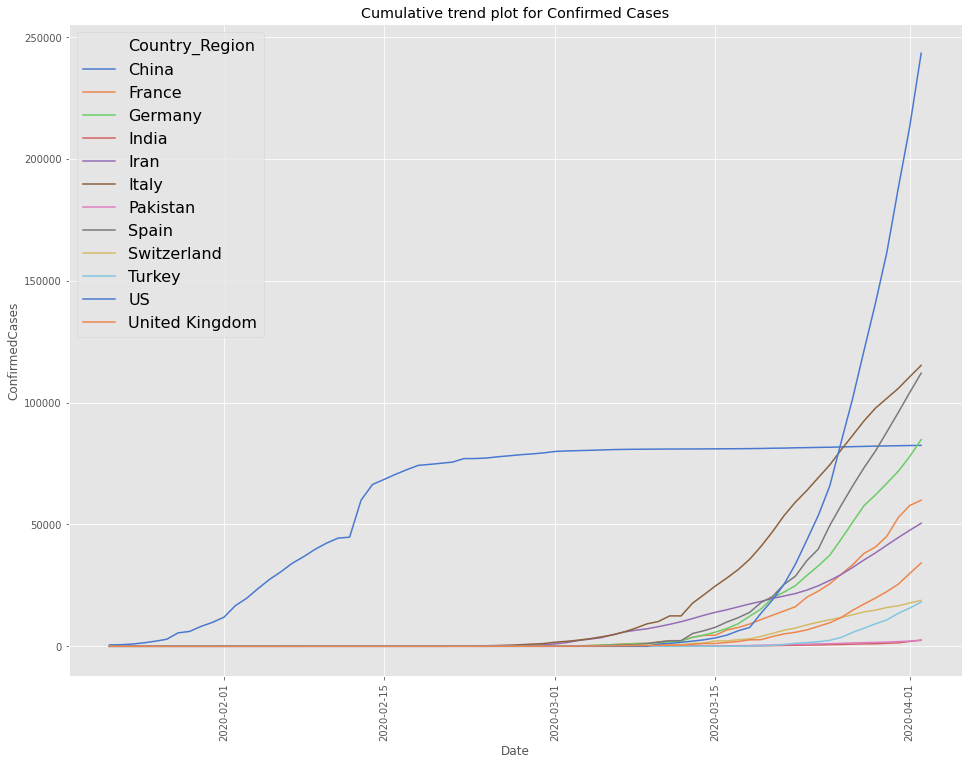

In [15]:
times_series_cntr = train_df.groupby(['Date','Country_Region'])['ConfirmedCases'].sum()\
                    .reset_index().set_index('Date')
df_countries_tm = times_series_cntr[times_series_cntr['Country_Region'].isin(list_countries)]


plt.figure(figsize=(16,12))
ax = sns.lineplot(x=df_countries_tm.index, 
                  y="ConfirmedCases", 
                  hue="Country_Region", 
                  data=df_countries_tm,palette='muted').set_title('Cumulative line')

plt.legend(loc=2, prop={'size': 16})
plt.title('Cumulative trend plot for Confirmed Cases')
plt.xticks(rotation=90);

In the above plot, we can see that China has stabilized its new case reporting while all other countries are showing increase in trend. There is huge variance in dates from when there has been sudden increase in cases.
UK has shown sudden increase in number of confirmed cases since 15 March 2020.

In [16]:
Confirm_pivot=pd.pivot_table(train_df,index='Date',columns='Country_Region',
                             values='ConfirmedCases',aggfunc=np.sum)
Confirm_pivot

Country_Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),...,Saint Lucia,Saint Vincent and the Grenadines,San Marino,Saudi Arabia,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Somalia,South Africa,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,548.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,643.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,920.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1406.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2075.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-29,120.0,212.0,511.0,334.0,7.0,7.0,745.0,424.0,3984.0,8788.0,209.0,11.0,499.0,48.0,33.0,94.0,10836.0,2.0,6.0,4.0,81.0,323.0,0.0,4256.0,126.0,346.0,222.0,10.0,0.0,6.0,103.0,139.0,6267.0,3.0,3.0,2139.0,82122.0,702.0,19.0,65.0,...,9.0,1.0,224.0,1299.0,142.0,741.0,8.0,0.0,844.0,314.0,730.0,3.0,1280.0,80110.0,117.0,6.0,8.0,3700.0,14829.0,9.0,298.0,14.0,1388.0,1.0,25.0,78.0,312.0,9217.0,140734.0,33.0,475.0,570.0,19780.0,304.0,144.0,119.0,188.0,109.0,29.0,7.0
2020-03-30,170.0,223.0,584.0,370.0,7.0,7.0,820.0,482.0,4361.0,9618.0,273.0,14.0,515.0,49.0,33.0,152.0,11899.0,3.0,6.0,4.0,97.0,368.0,3.0,4579.0,127.0,359.0,246.0,14.0,0.0,6.0,107.0,139.0,7385.0,3.0,5.0,2449.0,82198.0,798.0,19.0,81.0,...,9.0,1.0,230.0,1453.0,162.0,785.0,8.0,0.0,879.0,336.0,756.0,3.0,1326.0,87956.0,122.0,6.0,8.0,4028.0,15922.0,10.0,306.0,19.0,1524.0,1.0,30.0,82.0,312.0,10827.0,161655.0,33.0,548.0,611.0,22453.0,310.0,149.0,135.0,203.0,116.0,35.0,7.0
2020-03-31,174.0,243.0,716.0,376.0,7.0,7.0,1054.0,532.0,4559.0,10180.0,298.0,14.0,567.0,51.0,34.0,152.0,12775.0,3.0,9.0,4.0,107.0,420.

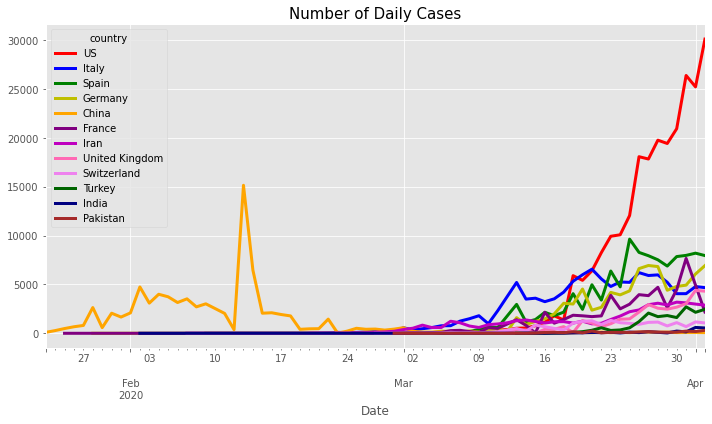

In [34]:
plt.figure(figsize=(10,6))
colors=['r','b','g','y','orange','purple','m','hotpink','violet','darkgreen','navy','brown']
for i,country in enumerate(list_countries):
    Confirm=Confirm_pivot[Confirm_pivot[country]>0][country].diff().fillna(0)
    Confirm=Confirm[Confirm>0]
    Confirm.plot(color=colors[i],label=country,markersize=8,lw=3)   
    plt.title('Number of Daily Cases',fontsize=15)
    plt.legend(title='country')
plt.tight_layout()

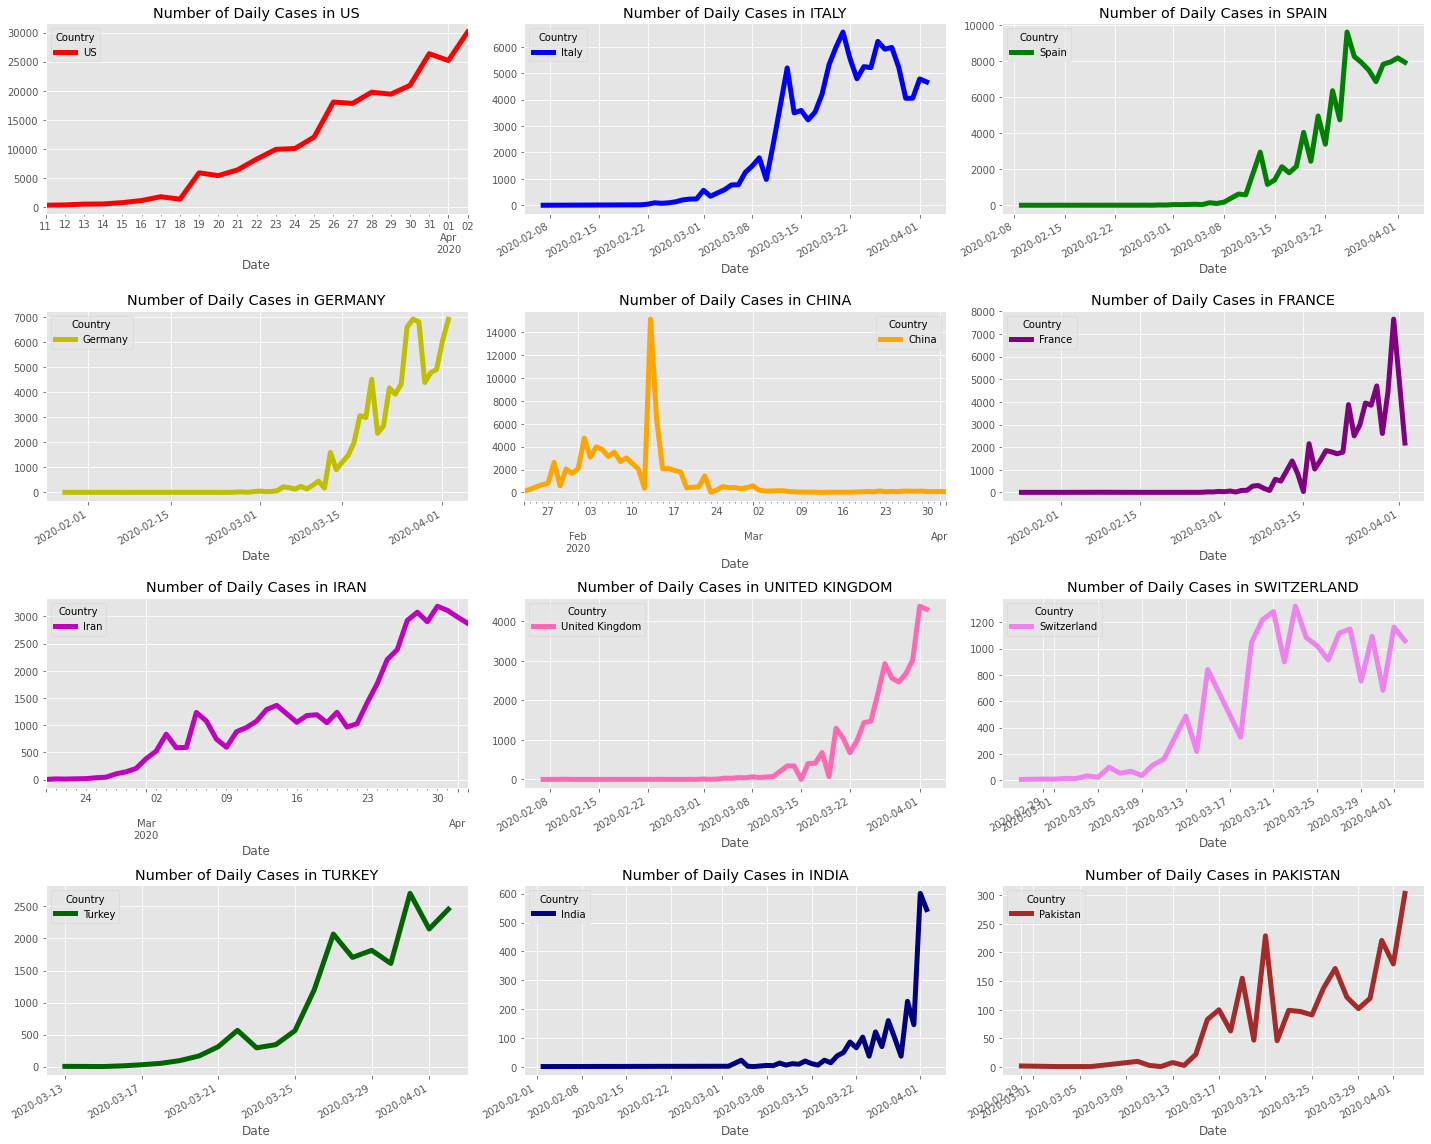

In [36]:
plt.figure(figsize=(20,16))
colors=['r','b','g','y','orange','purple','m','hotpink','violet','darkgreen','navy','brown']
for i,country in enumerate(list_countries):
    Confirm=Confirm_pivot[Confirm_pivot[country]>0][country].diff().fillna(0)
    Confirm=Confirm[Confirm>0]
    
    plt.subplot(4,3,i+1)
    Confirm.plot(color=colors[i],label=country,markersize=12,lw=5)    
    plt.xticks()
    plt.legend(title='Country')
    plt.title('Number of Daily Cases in {}'.format(country.upper()))
plt.tight_layout()

In [55]:
coun = []
maxi= []
id_m= []

for country in list_countries:
    id_max=Confirm_pivot[country].diff().fillna(0).idxmax()
    maxim=Confirm_pivot[country].diff().fillna(0).max()
    print('Maximum New Cases registered for {0} was {1} on {2}'.format(country,maxim,id_max))
    coun.append(country)
    maxi.append(maxim)
    id_m.append(id_max)

df_max_case = pd.DataFrame(list(zip(coun, maxi, id_m)), columns =['country', 'max_case', 'date']) 
df_max_case

df_max_case['date']=df_max_case['date'].astype(str)

Maximum New Cases registered for US was 30081.0 on 2020-04-02 00:00:00
Maximum New Cases registered for Italy was 6557.0 on 2020-03-21 00:00:00
Maximum New Cases registered for Spain was 9630.0 on 2020-03-25 00:00:00
Maximum New Cases registered for Germany was 6933.0 on 2020-03-27 00:00:00
Maximum New Cases registered for China was 15136.0 on 2020-02-13 00:00:00
Maximum New Cases registered for France was 7657.0 on 2020-03-31 00:00:00
Maximum New Cases registered for Iran was 3186.0 on 2020-03-30 00:00:00
Maximum New Cases registered for United Kingdom was 4384.0 on 2020-04-01 00:00:00
Maximum New Cases registered for Switzerland was 1321.0 on 2020-03-23 00:00:00
Maximum New Cases registered for Turkey was 2704.0 on 2020-03-31 00:00:00
Maximum New Cases registered for India was 601.0 on 2020-04-01 00:00:00
Maximum New Cases registered for Pakistan was 303.0 on 2020-04-02 00:00:00


In [56]:
fig = px.bar(df_max_case, x=df_max_case.country, y='max_case', text = 'date',
             labels={'x':'country'}, color="country", 
             color_continuous_scale=px.colors.sequential.Rainbow_r)
fig.update_layout(title_text='Date on which a top 12 countries had Maximum cases')
fig.show()

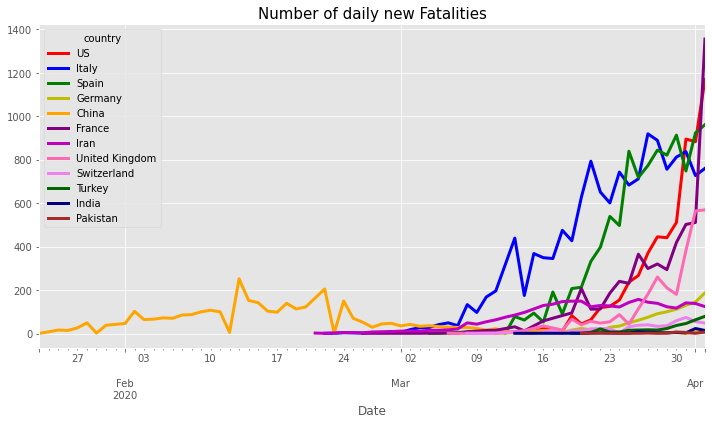

In [58]:
Fatal_pivot=pd.pivot_table(train_df,index='Date',
                           columns='Country_Region',
                           values='Fatalities',
                           aggfunc=np.sum)

plt.figure(figsize=(10,6))
colors=['r','b','g','y','orange','purple','m','hotpink','violet','darkgreen','navy','brown']
for i,country in enumerate(list_countries):
    Fatal_diff=Fatal_pivot[Fatal_pivot[country]>0][country].diff().fillna(0)
    Fatal_diff=Fatal_diff[Fatal_diff>0]
    Fatal_diff.plot(color=colors[i],label=country,markersize=8,lw=3)   
    plt.title('Number of daily new Fatalities',fontsize=15)
    plt.legend(title='country')
plt.tight_layout()

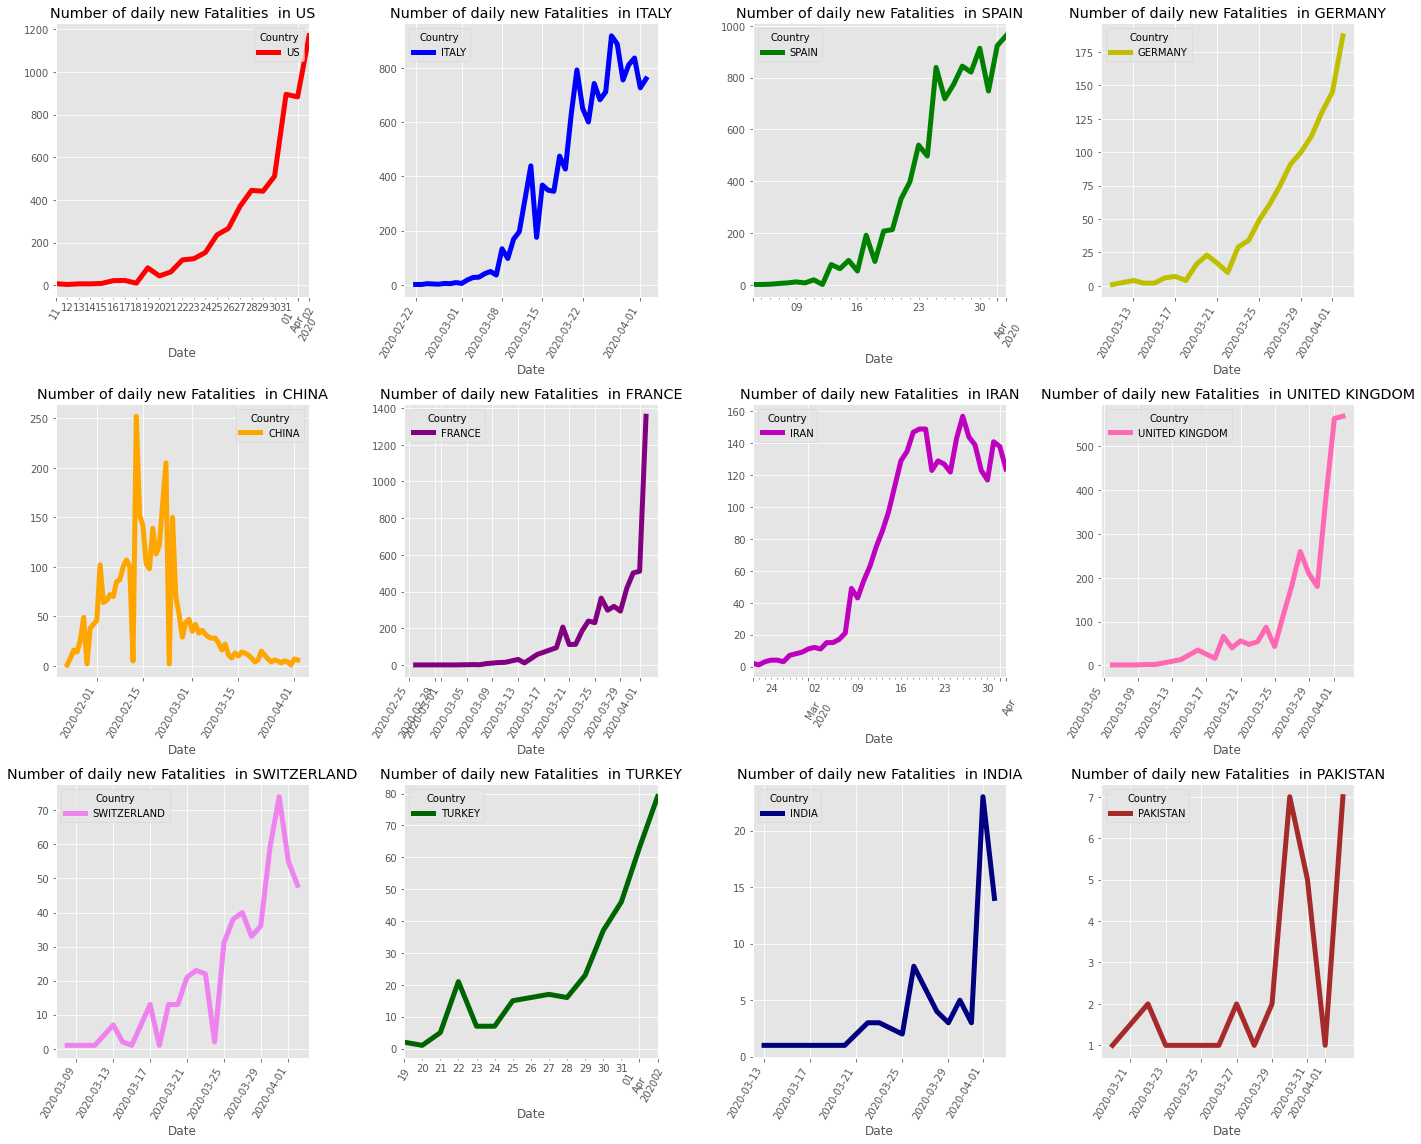

In [59]:
plt.figure(figsize=(20,16))
for i,country in enumerate(list_countries):
    Fatal_diff=Fatal_pivot[(Fatal_pivot[country]>0)][country].diff().fillna(0)
    Fatal_diff=Fatal_diff[Fatal_diff>0]
    plt.subplot(3,4,i+1)
    Fatal_diff.plot(color=colors[i],label=country.upper(),lw=5)
    plt.xticks(rotation=60)
    plt.title('Number of daily new Fatalities  in {}'.format(country.upper()))
    plt.legend(title='Country')
plt.tight_layout()

In [62]:
coun = []
maxi= []
id_m= []

for country in list_countries:
    id_max=Fatal_pivot[country].diff().fillna(0).idxmax()
    maxim=Fatal_pivot[country].diff().fillna(0).max()
    print('Maximum Fatalities for {0} was {1} on {2}'.format(country,maxim,id_max))
    coun.append(country)
    maxi.append(maxim)
    id_m.append(id_max)

df_max_fat = pd.DataFrame(list(zip(coun, maxi, id_m)), columns =['country', 'max_fat', 'date']) 
df_max_fat

df_max_fat['date']=df_max_fat['date'].astype(str)

Maximum Fatalities for US was 1169.0 on 2020-04-02 00:00:00
Maximum Fatalities for Italy was 919.0 on 2020-03-27 00:00:00
Maximum Fatalities for Spain was 961.0 on 2020-04-02 00:00:00
Maximum Fatalities for Germany was 187.0 on 2020-04-02 00:00:00
Maximum Fatalities for China was 252.0 on 2020-02-13 00:00:00
Maximum Fatalities for France was 1355.0 on 2020-04-02 00:00:00
Maximum Fatalities for Iran was 157.0 on 2020-03-26 00:00:00
Maximum Fatalities for United Kingdom was 569.0 on 2020-04-02 00:00:00
Maximum Fatalities for Switzerland was 74.0 on 2020-03-31 00:00:00
Maximum Fatalities for Turkey was 79.0 on 2020-04-02 00:00:00
Maximum Fatalities for India was 23.0 on 2020-04-01 00:00:00
Maximum Fatalities for Pakistan was 7.0 on 2020-03-30 00:00:00


In [63]:
fig = px.bar(df_max_fat, x=df_max_fat.country, y='max_fat', text = 'date',
             labels={'x':'country'}, color="country", 
             color_continuous_scale=px.colors.sequential.Rainbow_r)
fig.update_layout(title_text='Date on which a top 12 countries had Maximum Fatalities')
fig.show()

Text(0.5, 0.98, 'Variation in number of confirmed cases on daily basis')

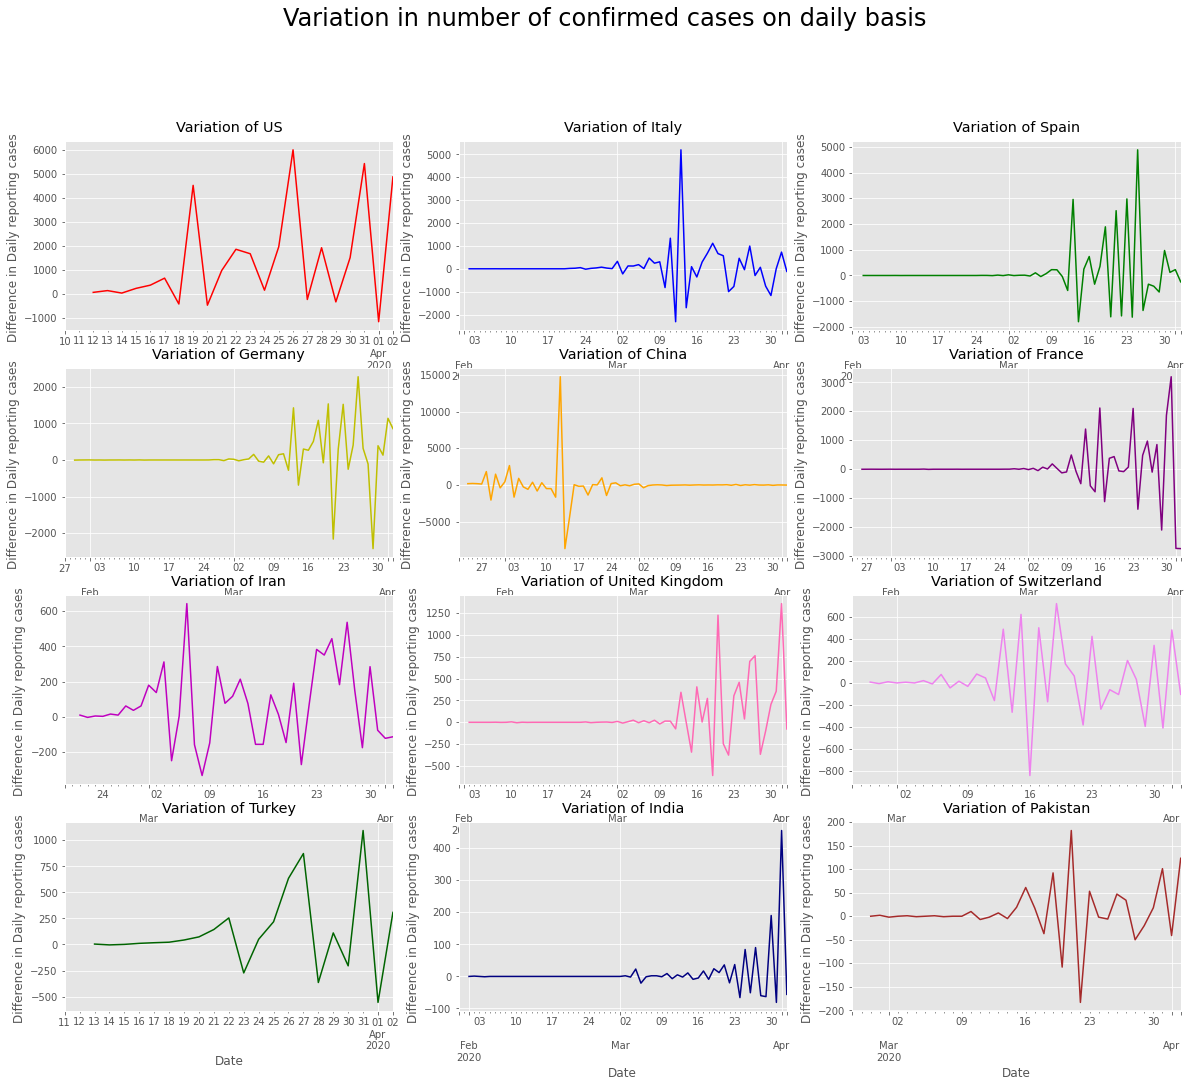

In [64]:
# Understanding New cases confirmation variations on daily basis
plt.figure(figsize=(20,16))
for i,country in enumerate(list_countries):
    plt.subplot(4,3,i+1)
    train_df[(train_df['Country_Region']==country)&(train_df['ConfirmedCases']!=0)].groupby('Date')['ConfirmedCases'].sum().diff().diff().plot(color=colors[i])
    plt.ylabel('Difference in Daily reporting cases ')
    plt.title('Variation of {}'.format(country),va='bottom')
plt.suptitle('Variation in number of confirmed cases on daily basis',fontsize=24,va='baseline')